In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/mcdori/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Let's load our mnist data

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train.shape

(60000, 28, 28)

#### Let's train our simple neural network to predict handwritten digits

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
60000/60000 [==============================]60000/60000 [==============================] - 26s 427us/step - loss: 0.2184 - acc: 0.9353

Epoch 2/5
60000/60000 [==============================]60000/60000 [==============================] - 24s 406us/step - loss: 0.0965 - acc: 0.9705

Epoch 3/5
60000/60000 [==============================]60000/60000 [==============================] - 25s 421us/step - loss: 0.0709 - acc: 0.9775

Epoch 4/5
60000/60000 [==============================]60000/60000 [==============================] - 27s 454us/step - loss: 0.0553 - acc: 0.9825

Epoch 5/5
60000/60000 [==============================]60000/60000 [==============================] - 24s 398us/step - loss: 0.0433 - acc: 0.9858



#### Let's evaluate our model

In [7]:
model.evaluate(x_test, y_test)

10000/10000 [==============================]10000/10000 [==============================] - 1s 79us/step



[0.06207441001039697, 0.9818]

We can see that our model does pretty well and achieves areound **98%** accuracy

#### Let's now extract all the images of the digit 2 that we have

In [8]:
idx_train = np.where(y_train == 2)
x_train_two = x_train[idx_train]
y_train_two = y_train[idx_train]
num_samples = x_train_two.shape[0]

#### Let's visualize a few random examples of the digit two

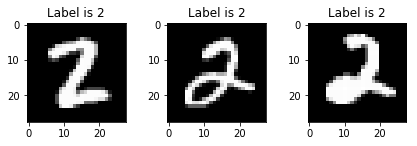

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.tight_layout()
for col in ax:
    ix = np.random.choice(num_samples)
    col.set_title('Label is {label}'.format(label=y_train_two[ix]))
    col.imshow(x_train_two[ix], cmap='gray')
plt.show()

We now need to find a way to make our original network predict that these images of the digit "2" as "6". To do that we have to someohow tweak the pixels in the images of "2", but only so much so that they still look like the digit "2" to the human eye. So we can sum this up with two constraints:

* We want to maximize the probability output of our original neural network that the image is the digit 6
* We want to minimize how much we change the images so that they don't change too much to the human eye. 

We'll use the idea from the following blog post: https://medium.com/@ageitgey/machine-learning-is-fun-part-8-how-to-intentionally-trick-neural-networks-b55da32b7196. We'll pick a sample image of two, pass it through our network and use a cost function to calculate the loss given that the image should be predicted as "6". We'll then calculate the gradients and tweak our image towards "6".

### Let's define a function that can give us the gradient and loss based on an image w.r.t to our preferred prediction

In [14]:
correct_label = 6
prob_func = model.layers[-1].output[0, correct_label] #this is the assigned probability of an image being a six
gradients_func = tf.keras.backend.gradients(prob_func, model.layers[0].input)[0] #the gradient to change the input to minimize our loss
grab_cost_and_gradients_from_model = tf.keras.backend.function([model.layers[0].input, tf.keras.backend.learning_phase()], [prob_func, gradients_func])

In [29]:
prob = 0.0
learning_rate = 1000
hacked_image = np.copy(x_train_two[0])
hacked_image = np.expand_dims(hacked_image, axis=0)
max_change_below = hacked_image + 0.01
max_change_above = hacked_image - 0.01
# In a loop, keep adjusting the hacked image slightly so that it tricks the model more and more
# until it gets to at least 80% confidence
while prob < 0.8:
    # Check how close the image is to our target class and grab the gradients we
    # can use to push it one more step in that direction.
    # Note: It's really important to pass in '0' for the Keras learning mode here!
    # Keras layers behave differently in prediction vs. train modes!
    
    prob, gradients = grab_cost_and_gradients_from_model([hacked_image, 0])
    #print(loss)
    #print(np.mean(gradients-bla))
    #print(np.mean(gradients * learning_rate))
    # Move the hacked image one step further towards fooling the model
    old_image = hacked_image
    #print("image:" + str(hacked_image[0][0][0]))
    #print("gradient: " + str(gradients[0][0][0]))
    hacked_image += gradients * learning_rate
    #print("added:" + str(gradients[0][0][0] * learning_rate))
    # Ensure that the image doesn't ever change too much to either look funny or to become an invalid image
    #hacked_image = np.clip(hacked_image, max_change_below, max_change_above)
    #hacked_image = np.clip(hacked_image, -1.0, 1.0)

    print("Model's predicted likelihood that the image is a six: {:.8}%".format(prob * 100))

Model's predicted likelihood that the image is a six: 6.9809208e-08%
Model's predicted likelihood that the image is a six: 6.9817863e-08%
Model's predicted likelihood that the image is a six: 6.9826522e-08%
Model's predicted likelihood that the image is a six: 6.9835315e-08%
Model's predicted likelihood that the image is a six: 6.9843842e-08%
Model's predicted likelihood that the image is a six: 6.9852496e-08%
Model's predicted likelihood that the image is a six: 6.9861422e-08%
Model's predicted likelihood that the image is a six: 6.9869949e-08%
Model's predicted likelihood that the image is a six: 6.9878747e-08%
Model's predicted likelihood that the image is a six: 6.9887279e-08%
Model's predicted likelihood that the image is a six: 6.9896072e-08%
Model's predicted likelihood that the image is a six: 6.9904876e-08%
Model's predicted likelihood that the image is a six: 6.9913408e-08%
Model's predicted likelihood that the image is a six: 6.9922212e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 7.0981326e-08%
Model's predicted likelihood that the image is a six: 7.0990125e-08%
Model's predicted likelihood that the image is a six: 7.0999201e-08%
Model's predicted likelihood that the image is a six: 7.1008138e-08%
Model's predicted likelihood that the image is a six: 7.1017348e-08%
Model's predicted likelihood that the image is a six: 7.1026152e-08%
Model's predicted likelihood that the image is a six: 7.1034961e-08%
Model's predicted likelihood that the image is a six: 7.1044176e-08%
Model's predicted likelihood that the image is a six: 7.1053119e-08%
Model's predicted likelihood that the image is a six: 7.1061929e-08%
Model's predicted likelihood that the image is a six: 7.107101e-08%
Model's predicted likelihood that the image is a six: 7.1079959e-08%
Model's predicted likelihood that the image is a six: 7.1089035e-08%
Model's predicted likelihood that the image is a six: 7.1097983e-08%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 7.3416279e-08%
Model's predicted likelihood that the image is a six: 7.3425799e-08%
Model's predicted likelihood that the image is a six: 7.3435324e-08%
Model's predicted likelihood that the image is a six: 7.344485e-08%
Model's predicted likelihood that the image is a six: 7.3454376e-08%
Model's predicted likelihood that the image is a six: 7.3463907e-08%
Model's predicted likelihood that the image is a six: 7.3473433e-08%
Model's predicted likelihood that the image is a six: 7.3482964e-08%
Model's predicted likelihood that the image is a six: 7.3492495e-08%
Model's predicted likelihood that the image is a six: 7.3501888e-08%
Model's predicted likelihood that the image is a six: 7.3511425e-08%
Model's predicted likelihood that the image is a six: 7.3521095e-08%
Model's predicted likelihood that the image is a six: 7.3530626e-08%
Model's predicted likelihood that the image is a six: 7.354003e-08%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 7.4969436e-08%
Model's predicted likelihood that the image is a six: 7.4979445e-08%
Model's predicted likelihood that the image is a six: 7.498917e-08%
Model's predicted likelihood that the image is a six: 7.4999185e-08%
Model's predicted likelihood that the image is a six: 7.5009338e-08%
Model's predicted likelihood that the image is a six: 7.5019213e-08%
Model's predicted likelihood that the image is a six: 7.5028944e-08%
Model's predicted likelihood that the image is a six: 7.5038964e-08%
Model's predicted likelihood that the image is a six: 7.5048978e-08%
Model's predicted likelihood that the image is a six: 7.5059003e-08%
Model's predicted likelihood that the image is a six: 7.506874e-08%
Model's predicted likelihood that the image is a six: 7.5078904e-08%
Model's predicted likelihood that the image is a six: 7.5088502e-08%
Model's predicted likelihood that the image is a six: 7.5098672e-08%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 7.6352735e-08%
Model's predicted likelihood that the image is a six: 7.6363077e-08%
Model's predicted likelihood that the image is a six: 7.637313e-08%
Model's predicted likelihood that the image is a six: 7.6383622e-08%
Model's predicted likelihood that the image is a six: 7.6393813e-08%
Model's predicted likelihood that the image is a six: 7.6404161e-08%
Model's predicted likelihood that the image is a six: 7.6414508e-08%
Model's predicted likelihood that the image is a six: 7.6424711e-08%
Model's predicted likelihood that the image is a six: 7.6435208e-08%
Model's predicted likelihood that the image is a six: 7.6445122e-08%
Model's predicted likelihood that the image is a six: 7.645562e-08%
Model's predicted likelihood that the image is a six: 7.6466122e-08%
Model's predicted likelihood that the image is a six: 7.6476186e-08%
Model's predicted likelihood that the image is a six: 7.6486689e-08%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 7.78628e-08%
Model's predicted likelihood that the image is a six: 7.7873491e-08%
Model's predicted likelihood that the image is a six: 7.7884038e-08%
Model's predicted likelihood that the image is a six: 7.7894885e-08%
Model's predicted likelihood that the image is a six: 7.7905582e-08%
Model's predicted likelihood that the image is a six: 7.7916285e-08%
Model's predicted likelihood that the image is a six: 7.7926837e-08%
Model's predicted likelihood that the image is a six: 7.793739e-08%
Model's predicted likelihood that the image is a six: 7.7948537e-08%
Model's predicted likelihood that the image is a six: 7.7958795e-08%
Model's predicted likelihood that the image is a six: 7.7969503e-08%
Model's predicted likelihood that the image is a six: 7.7980356e-08%
Model's predicted likelihood that the image is a six: 7.7990919e-08%
Model's predicted likelihood that the image is a six: 7.8002077e-08%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 7.9455892e-08%
Model's predicted likelihood that the image is a six: 7.9467111e-08%
Model's predicted likelihood that the image is a six: 7.9478174e-08%
Model's predicted likelihood that the image is a six: 7.9489243e-08%
Model's predicted likelihood that the image is a six: 7.9500312e-08%
Model's predicted likelihood that the image is a six: 7.9511381e-08%
Model's predicted likelihood that the image is a six: 7.9522749e-08%
Model's predicted likelihood that the image is a six: 7.9533979e-08%
Model's predicted likelihood that the image is a six: 7.9544898e-08%
Model's predicted likelihood that the image is a six: 7.9555823e-08%
Model's predicted likelihood that the image is a six: 7.9567358e-08%
Model's predicted likelihood that the image is a six: 7.9578288e-08%
Model's predicted likelihood that the image is a six: 7.9589518e-08%
Model's predicted likelihood that the image is a six: 7.9600754e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 8.1173179e-08%
Model's predicted likelihood that the image is a six: 8.1184948e-08%
Model's predicted likelihood that the image is a six: 8.1197027e-08%
Model's predicted likelihood that the image is a six: 8.1208179e-08%
Model's predicted likelihood that the image is a six: 8.1220108e-08%
Model's predicted likelihood that the image is a six: 8.1231721e-08%
Model's predicted likelihood that the image is a six: 8.1243184e-08%
Model's predicted likelihood that the image is a six: 8.1254653e-08%
Model's predicted likelihood that the image is a six: 8.1266432e-08%
Model's predicted likelihood that the image is a six: 8.1278217e-08%
Model's predicted likelihood that the image is a six: 8.1290003e-08%
Model's predicted likelihood that the image is a six: 8.1301782e-08%
Model's predicted likelihood that the image is a six: 8.1313417e-08%
Model's predicted likelihood that the image is a six: 8.1324897e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 8.3295992e-08%
Model's predicted likelihood that the image is a six: 8.3308549e-08%
Model's predicted likelihood that the image is a six: 8.3320623e-08%
Model's predicted likelihood that the image is a six: 8.3333024e-08%
Model's predicted likelihood that the image is a six: 8.3345103e-08%
Model's predicted likelihood that the image is a six: 8.3357504e-08%
Model's predicted likelihood that the image is a six: 8.3369589e-08%
Model's predicted likelihood that the image is a six: 8.3381996e-08%
Model's predicted likelihood that the image is a six: 8.3394397e-08%
Model's predicted likelihood that the image is a six: 8.3406487e-08%
Model's predicted likelihood that the image is a six: 8.3419055e-08%
Model's predicted likelihood that the image is a six: 8.3431306e-08%
Model's predicted likelihood that the image is a six: 8.3443563e-08%
Model's predicted likelihood that the image is a six: 8.3455498e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 8.5122254e-08%
Model's predicted likelihood that the image is a six: 8.5134916e-08%
Model's predicted likelihood that the image is a six: 8.5147583e-08%
Model's predicted likelihood that the image is a six: 8.5160085e-08%
Model's predicted likelihood that the image is a six: 8.5173246e-08%
Model's predicted likelihood that the image is a six: 8.5185914e-08%
Model's predicted likelihood that the image is a six: 8.5198915e-08%
Model's predicted likelihood that the image is a six: 8.5211754e-08%
Model's predicted likelihood that the image is a six: 8.52246e-08%
Model's predicted likelihood that the image is a six: 8.5237278e-08%
Model's predicted likelihood that the image is a six: 8.5249963e-08%
Model's predicted likelihood that the image is a six: 8.5262647e-08%
Model's predicted likelihood that the image is a six: 8.5275659e-08%
Model's predicted likelihood that the image is a six: 8.5288665e-08%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 8.7418833e-08%
Model's predicted likelihood that the image is a six: 8.7432339e-08%
Model's predicted likelihood that the image is a six: 8.7445851e-08%
Model's predicted likelihood that the image is a six: 8.7459195e-08%
Model's predicted likelihood that the image is a six: 8.747254e-08%
Model's predicted likelihood that the image is a six: 8.7486224e-08%
Model's predicted likelihood that the image is a six: 8.7499907e-08%
Model's predicted likelihood that the image is a six: 8.7513424e-08%
Model's predicted likelihood that the image is a six: 8.7527113e-08%
Model's predicted likelihood that the image is a six: 8.7540303e-08%
Model's predicted likelihood that the image is a six: 8.7553831e-08%
Model's predicted likelihood that the image is a six: 8.7567359e-08%
Model's predicted likelihood that the image is a six: 8.758072e-08%
Model's predicted likelihood that the image is a six: 8.7594421e-08%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 8.9136692e-08%
Model's predicted likelihood that the image is a six: 8.9150809e-08%
Model's predicted likelihood that the image is a six: 8.9164925e-08%
Model's predicted likelihood that the image is a six: 8.917887e-08%
Model's predicted likelihood that the image is a six: 8.9192986e-08%
Model's predicted likelihood that the image is a six: 8.9207108e-08%
Model's predicted likelihood that the image is a six: 8.9220892e-08%
Model's predicted likelihood that the image is a six: 8.9235175e-08%
Model's predicted likelihood that the image is a six: 8.9249136e-08%
Model's predicted likelihood that the image is a six: 8.9263091e-08%
Model's predicted likelihood that the image is a six: 8.9277058e-08%
Model's predicted likelihood that the image is a six: 8.9291363e-08%
Model's predicted likelihood that the image is a six: 8.930533e-08%
Model's predicted likelihood that the image is a six: 8.9319296e-08%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 9.0938251e-08%
Model's predicted likelihood that the image is a six: 9.0952823e-08%
Model's predicted likelihood that the image is a six: 9.0967395e-08%
Model's predicted likelihood that the image is a six: 9.0982144e-08%
Model's predicted likelihood that the image is a six: 9.0996549e-08%
Model's predicted likelihood that the image is a six: 9.1011304e-08%
Model's predicted likelihood that the image is a six: 9.1025715e-08%
Model's predicted likelihood that the image is a six: 9.1040298e-08%
Model's predicted likelihood that the image is a six: 9.1054714e-08%
Model's predicted likelihood that the image is a six: 9.1069824e-08%
Model's predicted likelihood that the image is a six: 9.1084412e-08%
Model's predicted likelihood that the image is a six: 9.1099006e-08%
Model's predicted likelihood that the image is a six: 9.1113606e-08%
Model's predicted likelihood that the image is a six: 9.1128205e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 9.2768421e-08%
Model's predicted likelihood that the image is a six: 9.2783464e-08%
Model's predicted likelihood that the image is a six: 9.2798685e-08%
Model's predicted likelihood that the image is a six: 9.2813734e-08%
Model's predicted likelihood that the image is a six: 9.2828956e-08%
Model's predicted likelihood that the image is a six: 9.284436e-08%
Model's predicted likelihood that the image is a six: 9.2859592e-08%
Model's predicted likelihood that the image is a six: 9.2874824e-08%
Model's predicted likelihood that the image is a six: 9.2889707e-08%
Model's predicted likelihood that the image is a six: 9.29053e-08%
Model's predicted likelihood that the image is a six: 9.2920543e-08%
Model's predicted likelihood that the image is a six: 9.2935609e-08%
Model's predicted likelihood that the image is a six: 9.2950675e-08%
Model's predicted likelihood that the image is a six: 9.2965918e-08%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 9.4643027e-08%
Model's predicted likelihood that the image is a six: 9.4658548e-08%
Model's predicted likelihood that the image is a six: 9.4673902e-08%
Model's predicted likelihood that the image is a six: 9.4689967e-08%
Model's predicted likelihood that the image is a six: 9.4705688e-08%
Model's predicted likelihood that the image is a six: 9.4721397e-08%
Model's predicted likelihood that the image is a six: 9.4736929e-08%
Model's predicted likelihood that the image is a six: 9.4752473e-08%
Model's predicted likelihood that the image is a six: 9.4768016e-08%
Model's predicted likelihood that the image is a six: 9.4783925e-08%
Model's predicted likelihood that the image is a six: 9.4799479e-08%
Model's predicted likelihood that the image is a six: 9.4815022e-08%
Model's predicted likelihood that the image is a six: 9.4830588e-08%
Model's predicted likelihood that the image is a six: 9.4846497e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 9.7340813e-08%
Model's predicted likelihood that the image is a six: 9.7357522e-08%
Model's predicted likelihood that the image is a six: 9.7374231e-08%
Model's predicted likelihood that the image is a six: 9.7390573e-08%
Model's predicted likelihood that the image is a six: 9.7406927e-08%
Model's predicted likelihood that the image is a six: 9.7423281e-08%
Model's predicted likelihood that the image is a six: 9.7440001e-08%
Model's predicted likelihood that the image is a six: 9.7456732e-08%
Model's predicted likelihood that the image is a six: 9.7473285e-08%
Model's predicted likelihood that the image is a six: 9.7490005e-08%
Model's predicted likelihood that the image is a six: 9.7506181e-08%
Model's predicted likelihood that the image is a six: 9.7522923e-08%
Model's predicted likelihood that the image is a six: 9.7539476e-08%
Model's predicted likelihood that the image is a six: 9.7556041e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 9.9415443e-08%
Model's predicted likelihood that the image is a six: 9.9433084e-08%
Model's predicted likelihood that the image is a six: 9.9449771e-08%
Model's predicted likelihood that the image is a six: 9.9467212e-08%
Model's predicted likelihood that the image is a six: 9.9484665e-08%
Model's predicted likelihood that the image is a six: 9.9501751e-08%
Model's predicted likelihood that the image is a six: 9.9518838e-08%
Model's predicted likelihood that the image is a six: 9.9536301e-08%
Model's predicted likelihood that the image is a six: 9.9553765e-08%
Model's predicted likelihood that the image is a six: 9.9570863e-08%
Model's predicted likelihood that the image is a six: 9.9588338e-08%
Model's predicted likelihood that the image is a six: 9.9605246e-08%
Model's predicted likelihood that the image is a six: 9.9622721e-08%
Model's predicted likelihood that the image is a six: 9.9640207e-08%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 1.0174289e-07%
Model's predicted likelihood that the image is a six: 1.0176113e-07%
Model's predicted likelihood that the image is a six: 1.0177937e-07%
Model's predicted likelihood that the image is a six: 1.0179685e-07%
Model's predicted likelihood that the image is a six: 1.018151e-07%
Model's predicted likelihood that the image is a six: 1.0183335e-07%
Model's predicted likelihood that the image is a six: 1.0185162e-07%
Model's predicted likelihood that the image is a six: 1.0186929e-07%
Model's predicted likelihood that the image is a six: 1.0188755e-07%
Model's predicted likelihood that the image is a six: 1.0190563e-07%
Model's predicted likelihood that the image is a six: 1.0192351e-07%
Model's predicted likelihood that the image is a six: 1.0194179e-07%
Model's predicted likelihood that the image is a six: 1.0196007e-07%
Model's predicted likelihood that the image is a six: 1.0197777e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 1.039363e-07%
Model's predicted likelihood that the image is a six: 1.0395553e-07%
Model's predicted likelihood that the image is a six: 1.0397417e-07%
Model's predicted likelihood that the image is a six: 1.0399321e-07%
Model's predicted likelihood that the image is a six: 1.0401185e-07%
Model's predicted likelihood that the image is a six: 1.040309e-07%
Model's predicted likelihood that the image is a six: 1.0404956e-07%
Model's predicted likelihood that the image is a six: 1.0406861e-07%
Model's predicted likelihood that the image is a six: 1.0408747e-07%
Model's predicted likelihood that the image is a six: 1.0410633e-07%
Model's predicted likelihood that the image is a six: 1.04125e-07%
Model's predicted likelihood that the image is a six: 1.0414407e-07%
Model's predicted likelihood that the image is a six: 1.0416275e-07%
Model's predicted likelihood that the image is a six: 1.0418222e-07%
Model's predicted likelihood that the 

Model's predicted likelihood that the image is a six: 1.0662147e-07%
Model's predicted likelihood that the image is a six: 1.066412e-07%
Model's predicted likelihood that the image is a six: 1.0666092e-07%
Model's predicted likelihood that the image is a six: 1.0668106e-07%
Model's predicted likelihood that the image is a six: 1.067008e-07%
Model's predicted likelihood that the image is a six: 1.0672074e-07%
Model's predicted likelihood that the image is a six: 1.0674027e-07%
Model's predicted likelihood that the image is a six: 1.0676063e-07%
Model's predicted likelihood that the image is a six: 1.067806e-07%
Model's predicted likelihood that the image is a six: 1.0680016e-07%
Model's predicted likelihood that the image is a six: 1.0682012e-07%
Model's predicted likelihood that the image is a six: 1.0684009e-07%
Model's predicted likelihood that the image is a six: 1.0686007e-07%
Model's predicted likelihood that the image is a six: 1.0687963e-07%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 1.0987926e-07%
Model's predicted likelihood that the image is a six: 1.0990022e-07%
Model's predicted likelihood that the image is a six: 1.0992055e-07%
Model's predicted likelihood that the image is a six: 1.0994152e-07%
Model's predicted likelihood that the image is a six: 1.0996227e-07%
Model's predicted likelihood that the image is a six: 1.0998326e-07%
Model's predicted likelihood that the image is a six: 1.1000465e-07%
Model's predicted likelihood that the image is a six: 1.1002521e-07%
Model's predicted likelihood that the image is a six: 1.1004599e-07%
Model's predicted likelihood that the image is a six: 1.1006678e-07%
Model's predicted likelihood that the image is a six: 1.1008777e-07%
Model's predicted likelihood that the image is a six: 1.1010857e-07%
Model's predicted likelihood that the image is a six: 1.1012957e-07%
Model's predicted likelihood that the image is a six: 1.1015058e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 1.1296178e-07%
Model's predicted likelihood that the image is a six: 1.1298377e-07%
Model's predicted likelihood that the image is a six: 1.1300575e-07%
Model's predicted likelihood that the image is a six: 1.130273e-07%
Model's predicted likelihood that the image is a six: 1.1304973e-07%
Model's predicted likelihood that the image is a six: 1.1307172e-07%
Model's predicted likelihood that the image is a six: 1.1309372e-07%
Model's predicted likelihood that the image is a six: 1.1311573e-07%
Model's predicted likelihood that the image is a six: 1.1313774e-07%
Model's predicted likelihood that the image is a six: 1.1315997e-07%
Model's predicted likelihood that the image is a six: 1.1318197e-07%
Model's predicted likelihood that the image is a six: 1.1320421e-07%
Model's predicted likelihood that the image is a six: 1.1322624e-07%
Model's predicted likelihood that the image is a six: 1.1324871e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 1.1629193e-07%
Model's predicted likelihood that the image is a six: 1.1631521e-07%
Model's predicted likelihood that the image is a six: 1.1633828e-07%
Model's predicted likelihood that the image is a six: 1.163618e-07%
Model's predicted likelihood that the image is a six: 1.1638533e-07%
Model's predicted likelihood that the image is a six: 1.1640887e-07%
Model's predicted likelihood that the image is a six: 1.1643219e-07%
Model's predicted likelihood that the image is a six: 1.164555e-07%
Model's predicted likelihood that the image is a six: 1.164786e-07%
Model's predicted likelihood that the image is a six: 1.1650215e-07%
Model's predicted likelihood that the image is a six: 1.1652527e-07%
Model's predicted likelihood that the image is a six: 1.1654927e-07%
Model's predicted likelihood that the image is a six: 1.165724e-07%
Model's predicted likelihood that the image is a six: 1.1659597e-07%
Model's predicted likelihood that the 

Model's predicted likelihood that the image is a six: 1.1913529e-07%
Model's predicted likelihood that the image is a six: 1.191596e-07%
Model's predicted likelihood that the image is a six: 1.1918437e-07%
Model's predicted likelihood that the image is a six: 1.1920848e-07%
Model's predicted likelihood that the image is a six: 1.1923302e-07%
Model's predicted likelihood that the image is a six: 1.1925781e-07%
Model's predicted likelihood that the image is a six: 1.1928216e-07%
Model's predicted likelihood that the image is a six: 1.1930673e-07%
Model's predicted likelihood that the image is a six: 1.1933154e-07%
Model's predicted likelihood that the image is a six: 1.1935635e-07%
Model's predicted likelihood that the image is a six: 1.1938047e-07%
Model's predicted likelihood that the image is a six: 1.194053e-07%
Model's predicted likelihood that the image is a six: 1.194299e-07%
Model's predicted likelihood that the image is a six: 1.1945427e-07%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 1.22819e-07%
Model's predicted likelihood that the image is a six: 1.2284594e-07%
Model's predicted likelihood that the image is a six: 1.2287102e-07%
Model's predicted likelihood that the image is a six: 1.2289774e-07%
Model's predicted likelihood that the image is a six: 1.2292353e-07%
Model's predicted likelihood that the image is a six: 1.2294979e-07%
Model's predicted likelihood that the image is a six: 1.2297605e-07%
Model's predicted likelihood that the image is a six: 1.2300185e-07%
Model's predicted likelihood that the image is a six: 1.2302813e-07%
Model's predicted likelihood that the image is a six: 1.2305442e-07%
Model's predicted likelihood that the image is a six: 1.2308025e-07%
Model's predicted likelihood that the image is a six: 1.2310654e-07%
Model's predicted likelihood that the image is a six: 1.2313237e-07%
Model's predicted likelihood that the image is a six: 1.2315868e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 1.2687722e-07%
Model's predicted likelihood that the image is a six: 1.269053e-07%
Model's predicted likelihood that the image is a six: 1.2693314e-07%
Model's predicted likelihood that the image is a six: 1.269605e-07%
Model's predicted likelihood that the image is a six: 1.2698859e-07%
Model's predicted likelihood that the image is a six: 1.2701645e-07%
Model's predicted likelihood that the image is a six: 1.2704432e-07%
Model's predicted likelihood that the image is a six: 1.2707194e-07%
Model's predicted likelihood that the image is a six: 1.2710005e-07%
Model's predicted likelihood that the image is a six: 1.2712816e-07%
Model's predicted likelihood that the image is a six: 1.2715582e-07%
Model's predicted likelihood that the image is a six: 1.2718347e-07%
Model's predicted likelihood that the image is a six: 1.2721161e-07%
Model's predicted likelihood that the image is a six: 1.2723926e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 1.3183927e-07%
Model's predicted likelihood that the image is a six: 1.3186918e-07%
Model's predicted likelihood that the image is a six: 1.3189911e-07%
Model's predicted likelihood that the image is a six: 1.319293e-07%
Model's predicted likelihood that the image is a six: 1.319595e-07%
Model's predicted likelihood that the image is a six: 1.319892e-07%
Model's predicted likelihood that the image is a six: 1.3201942e-07%
Model's predicted likelihood that the image is a six: 1.3204964e-07%
Model's predicted likelihood that the image is a six: 1.3207936e-07%
Model's predicted likelihood that the image is a six: 1.3210959e-07%
Model's predicted likelihood that the image is a six: 1.3213983e-07%
Model's predicted likelihood that the image is a six: 1.3216983e-07%
Model's predicted likelihood that the image is a six: 1.3220008e-07%
Model's predicted likelihood that the image is a six: 1.3223009e-07%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 1.3579143e-07%
Model's predicted likelihood that the image is a six: 1.3582302e-07%
Model's predicted likelihood that the image is a six: 1.3585488e-07%
Model's predicted likelihood that the image is a six: 1.3588677e-07%
Model's predicted likelihood that the image is a six: 1.3591865e-07%
Model's predicted likelihood that the image is a six: 1.3595028e-07%
Model's predicted likelihood that the image is a six: 1.3598216e-07%
Model's predicted likelihood that the image is a six: 1.3601433e-07%
Model's predicted likelihood that the image is a six: 1.3604599e-07%
Model's predicted likelihood that the image is a six: 1.3607765e-07%
Model's predicted likelihood that the image is a six: 1.3610983e-07%
Model's predicted likelihood that the image is a six: 1.3614202e-07%
Model's predicted likelihood that the image is a six: 1.3617423e-07%
Model's predicted likelihood that the image is a six: 1.3620566e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 1.4015631e-07%
Model's predicted likelihood that the image is a six: 1.4019054e-07%
Model's predicted likelihood that the image is a six: 1.4022423e-07%
Model's predicted likelihood that the image is a six: 1.4025794e-07%
Model's predicted likelihood that the image is a six: 1.4029166e-07%
Model's predicted likelihood that the image is a six: 1.403259e-07%
Model's predicted likelihood that the image is a six: 1.4036017e-07%
Model's predicted likelihood that the image is a six: 1.4039416e-07%
Model's predicted likelihood that the image is a six: 1.4042791e-07%
Model's predicted likelihood that the image is a six: 1.4046193e-07%
Model's predicted likelihood that the image is a six: 1.404957e-07%
Model's predicted likelihood that the image is a six: 1.4053e-07%
Model's predicted likelihood that the image is a six: 1.405643e-07%
Model's predicted likelihood that the image is a six: 1.4059863e-07%
Model's predicted likelihood that the im

Model's predicted likelihood that the image is a six: 1.4477554e-07%
Model's predicted likelihood that the image is a six: 1.4481172e-07%
Model's predicted likelihood that the image is a six: 1.4484791e-07%
Model's predicted likelihood that the image is a six: 1.4488412e-07%
Model's predicted likelihood that the image is a six: 1.4492003e-07%
Model's predicted likelihood that the image is a six: 1.4495625e-07%
Model's predicted likelihood that the image is a six: 1.4499303e-07%
Model's predicted likelihood that the image is a six: 1.4502899e-07%
Model's predicted likelihood that the image is a six: 1.4506523e-07%
Model's predicted likelihood that the image is a six: 1.4510149e-07%
Model's predicted likelihood that the image is a six: 1.4513799e-07%
Model's predicted likelihood that the image is a six: 1.4517398e-07%
Model's predicted likelihood that the image is a six: 1.4521081e-07%
Model's predicted likelihood that the image is a six: 1.452471e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 1.5068221e-07%
Model's predicted likelihood that the image is a six: 1.5072159e-07%
Model's predicted likelihood that the image is a six: 1.5076042e-07%
Model's predicted likelihood that the image is a six: 1.5079924e-07%
Model's predicted likelihood that the image is a six: 1.5083892e-07%
Model's predicted likelihood that the image is a six: 1.5087835e-07%
Model's predicted likelihood that the image is a six: 1.5091721e-07%
Model's predicted likelihood that the image is a six: 1.5095694e-07%
Model's predicted likelihood that the image is a six: 1.509961e-07%
Model's predicted likelihood that the image is a six: 1.5103526e-07%
Model's predicted likelihood that the image is a six: 1.5107445e-07%
Model's predicted likelihood that the image is a six: 1.5111391e-07%
Model's predicted likelihood that the image is a six: 1.5115341e-07%
Model's predicted likelihood that the image is a six: 1.511932e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 1.5586668e-07%
Model's predicted likelihood that the image is a six: 1.5590859e-07%
Model's predicted likelihood that the image is a six: 1.5594993e-07%
Model's predicted likelihood that the image is a six: 1.5599189e-07%
Model's predicted likelihood that the image is a six: 1.5603414e-07%
Model's predicted likelihood that the image is a six: 1.5607641e-07%
Model's predicted likelihood that the image is a six: 1.5611809e-07%
Model's predicted likelihood that the image is a six: 1.5616037e-07%
Model's predicted likelihood that the image is a six: 1.5620238e-07%
Model's predicted likelihood that the image is a six: 1.5624499e-07%
Model's predicted likelihood that the image is a six: 1.5628672e-07%
Model's predicted likelihood that the image is a six: 1.5632904e-07%
Model's predicted likelihood that the image is a six: 1.5637077e-07%
Model's predicted likelihood that the image is a six: 1.5641314e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 1.6142059e-07%
Model's predicted likelihood that the image is a six: 1.6146493e-07%
Model's predicted likelihood that the image is a six: 1.6151053e-07%
Model's predicted likelihood that the image is a six: 1.6155489e-07%
Model's predicted likelihood that the image is a six: 1.6160081e-07%
Model's predicted likelihood that the image is a six: 1.6164549e-07%
Model's predicted likelihood that the image is a six: 1.6168988e-07%
Model's predicted likelihood that the image is a six: 1.6173523e-07%
Model's predicted likelihood that the image is a six: 1.617809e-07%
Model's predicted likelihood that the image is a six: 1.6182626e-07%
Model's predicted likelihood that the image is a six: 1.6187071e-07%
Model's predicted likelihood that the image is a six: 1.6191641e-07%
Model's predicted likelihood that the image is a six: 1.6196089e-07%
Model's predicted likelihood that the image is a six: 1.6200662e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 1.6757817e-07%
Model's predicted likelihood that the image is a six: 1.6762645e-07%
Model's predicted likelihood that the image is a six: 1.6767473e-07%
Model's predicted likelihood that the image is a six: 1.6772304e-07%
Model's predicted likelihood that the image is a six: 1.6777262e-07%
Model's predicted likelihood that the image is a six: 1.6781999e-07%
Model's predicted likelihood that the image is a six: 1.678693e-07%
Model's predicted likelihood that the image is a six: 1.6791731e-07%
Model's predicted likelihood that the image is a six: 1.6796663e-07%
Model's predicted likelihood that the image is a six: 1.6801531e-07%
Model's predicted likelihood that the image is a six: 1.680634e-07%
Model's predicted likelihood that the image is a six: 1.6811212e-07%
Model's predicted likelihood that the image is a six: 1.6816087e-07%
Model's predicted likelihood that the image is a six: 1.6820962e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 1.7359739e-07%
Model's predicted likelihood that the image is a six: 1.7365038e-07%
Model's predicted likelihood that the image is a six: 1.7370271e-07%
Model's predicted likelihood that the image is a six: 1.7375441e-07%
Model's predicted likelihood that the image is a six: 1.7380611e-07%
Model's predicted likelihood that the image is a six: 1.7385851e-07%
Model's predicted likelihood that the image is a six: 1.7391023e-07%
Model's predicted likelihood that the image is a six: 1.7396266e-07%
Model's predicted likelihood that the image is a six: 1.7401509e-07%
Model's predicted likelihood that the image is a six: 1.7406688e-07%
Model's predicted likelihood that the image is a six: 1.7411934e-07%
Model's predicted likelihood that the image is a six: 1.7417215e-07%
Model's predicted likelihood that the image is a six: 1.7422366e-07%
Model's predicted likelihood that the image is a six: 1.7427616e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 1.8074062e-07%
Model's predicted likelihood that the image is a six: 1.8079682e-07%
Model's predicted likelihood that the image is a six: 1.8085304e-07%
Model's predicted likelihood that the image is a six: 1.8090962e-07%
Model's predicted likelihood that the image is a six: 1.8096622e-07%
Model's predicted likelihood that the image is a six: 1.8102281e-07%
Model's predicted likelihood that the image is a six: 1.8107911e-07%
Model's predicted likelihood that the image is a six: 1.8113611e-07%
Model's predicted likelihood that the image is a six: 1.8119207e-07%
Model's predicted likelihood that the image is a six: 1.8124876e-07%
Model's predicted likelihood that the image is a six: 1.8130547e-07%
Model's predicted likelihood that the image is a six: 1.8136218e-07%
Model's predicted likelihood that the image is a six: 1.8141892e-07%
Model's predicted likelihood that the image is a six: 1.8147569e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 1.9160058e-07%
Model's predicted likelihood that the image is a six: 1.9166273e-07%
Model's predicted likelihood that the image is a six: 1.9172453e-07%
Model's predicted likelihood that the image is a six: 1.9178708e-07%
Model's predicted likelihood that the image is a six: 1.9184963e-07%
Model's predicted likelihood that the image is a six: 1.9191182e-07%
Model's predicted likelihood that the image is a six: 1.9197335e-07%
Model's predicted likelihood that the image is a six: 1.9203523e-07%
Model's predicted likelihood that the image is a six: 1.9209787e-07%
Model's predicted likelihood that the image is a six: 1.9216055e-07%
Model's predicted likelihood that the image is a six: 1.9222324e-07%
Model's predicted likelihood that the image is a six: 1.9228557e-07%
Model's predicted likelihood that the image is a six: 1.9234792e-07%
Model's predicted likelihood that the image is a six: 1.9241067e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 2.0002446e-07%
Model's predicted likelihood that the image is a six: 2.0009125e-07%
Model's predicted likelihood that the image is a six: 2.0015958e-07%
Model's predicted likelihood that the image is a six: 2.0022715e-07%
Model's predicted likelihood that the image is a six: 2.0029474e-07%
Model's predicted likelihood that the image is a six: 2.0036275e-07%
Model's predicted likelihood that the image is a six: 2.0043081e-07%
Model's predicted likelihood that the image is a six: 2.0049848e-07%
Model's predicted likelihood that the image is a six: 2.0056694e-07%
Model's predicted likelihood that the image is a six: 2.0063429e-07%
Model's predicted likelihood that the image is a six: 2.0070279e-07%
Model's predicted likelihood that the image is a six: 2.0077093e-07%
Model's predicted likelihood that the image is a six: 2.0083875e-07%
Model's predicted likelihood that the image is a six: 2.0090694e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 2.0914752e-07%
Model's predicted likelihood that the image is a six: 2.0922213e-07%
Model's predicted likelihood that the image is a six: 2.0929558e-07%
Model's predicted likelihood that the image is a six: 2.0937025e-07%
Model's predicted likelihood that the image is a six: 2.0944415e-07%
Model's predicted likelihood that the image is a six: 2.0951805e-07%
Model's predicted likelihood that the image is a six: 2.0959239e-07%
Model's predicted likelihood that the image is a six: 2.0966677e-07%
Model's predicted likelihood that the image is a six: 2.0974116e-07%
Model's predicted likelihood that the image is a six: 2.0981556e-07%
Model's predicted likelihood that the image is a six: 2.0989042e-07%
Model's predicted likelihood that the image is a six: 2.0996451e-07%
Model's predicted likelihood that the image is a six: 2.1003941e-07%
Model's predicted likelihood that the image is a six: 2.101143e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 2.1881938e-07%
Model's predicted likelihood that the image is a six: 2.1890039e-07%
Model's predicted likelihood that the image is a six: 2.1898179e-07%
Model's predicted likelihood that the image is a six: 2.1906241e-07%
Model's predicted likelihood that the image is a six: 2.191435e-07%
Model's predicted likelihood that the image is a six: 2.1922502e-07%
Model's predicted likelihood that the image is a six: 2.1930653e-07%
Model's predicted likelihood that the image is a six: 2.1938855e-07%
Model's predicted likelihood that the image is a six: 2.1946891e-07%
Model's predicted likelihood that the image is a six: 2.1955098e-07%
Model's predicted likelihood that the image is a six: 2.196326e-07%
Model's predicted likelihood that the image is a six: 2.1971307e-07%
Model's predicted likelihood that the image is a six: 2.197948e-07%
Model's predicted likelihood that the image is a six: 2.1987654e-07%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 2.3341189e-07%
Model's predicted likelihood that the image is a six: 2.3350495e-07%
Model's predicted likelihood that the image is a six: 2.3359719e-07%
Model's predicted likelihood that the image is a six: 2.3368985e-07%
Model's predicted likelihood that the image is a six: 2.3378213e-07%
Model's predicted likelihood that the image is a six: 2.3387445e-07%
Model's predicted likelihood that the image is a six: 2.3396678e-07%
Model's predicted likelihood that the image is a six: 2.3405919e-07%
Model's predicted likelihood that the image is a six: 2.3415208e-07%
Model's predicted likelihood that the image is a six: 2.3424498e-07%
Model's predicted likelihood that the image is a six: 2.3433704e-07%
Model's predicted likelihood that the image is a six: 2.3443048e-07%
Model's predicted likelihood that the image is a six: 2.3452351e-07%
Model's predicted likelihood that the image is a six: 2.346161e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 2.4623938e-07%
Model's predicted likelihood that the image is a six: 2.4634181e-07%
Model's predicted likelihood that the image is a six: 2.4644426e-07%
Model's predicted likelihood that the image is a six: 2.4654718e-07%
Model's predicted likelihood that the image is a six: 2.4665021e-07%
Model's predicted likelihood that the image is a six: 2.467528e-07%
Model's predicted likelihood that the image is a six: 2.468554e-07%
Model's predicted likelihood that the image is a six: 2.4695854e-07%
Model's predicted likelihood that the image is a six: 2.4706222e-07%
Model's predicted likelihood that the image is a six: 2.471654e-07%
Model's predicted likelihood that the image is a six: 2.4726867e-07%
Model's predicted likelihood that the image is a six: 2.4737199e-07%
Model's predicted likelihood that the image is a six: 2.4747533e-07%
Model's predicted likelihood that the image is a six: 2.4757874e-07%
Model's predicted likelihood that the

Model's predicted likelihood that the image is a six: 2.7044442e-07%
Model's predicted likelihood that the image is a six: 2.7056821e-07%
Model's predicted likelihood that the image is a six: 2.7069313e-07%
Model's predicted likelihood that the image is a six: 2.7081604e-07%
Model's predicted likelihood that the image is a six: 2.7094005e-07%
Model's predicted likelihood that the image is a six: 2.7106406e-07%
Model's predicted likelihood that the image is a six: 2.7118818e-07%
Model's predicted likelihood that the image is a six: 2.7131339e-07%
Model's predicted likelihood that the image is a six: 2.7143761e-07%
Model's predicted likelihood that the image is a six: 2.7156244e-07%
Model's predicted likelihood that the image is a six: 2.7168727e-07%
Model's predicted likelihood that the image is a six: 2.7181168e-07%
Model's predicted likelihood that the image is a six: 2.7193663e-07%
Model's predicted likelihood that the image is a six: 2.7206168e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 2.8971916e-07%
Model's predicted likelihood that the image is a six: 2.898662e-07%
Model's predicted likelihood that the image is a six: 2.9001219e-07%
Model's predicted likelihood that the image is a six: 2.9016047e-07%
Model's predicted likelihood that the image is a six: 2.9030662e-07%
Model's predicted likelihood that the image is a six: 2.9045504e-07%
Model's predicted likelihood that the image is a six: 2.9060301e-07%
Model's predicted likelihood that the image is a six: 2.9074991e-07%
Model's predicted likelihood that the image is a six: 2.9089799e-07%
Model's predicted likelihood that the image is a six: 2.9104619e-07%
Model's predicted likelihood that the image is a six: 2.9119387e-07%
Model's predicted likelihood that the image is a six: 2.9134277e-07%
Model's predicted likelihood that the image is a six: 2.9149116e-07%
Model's predicted likelihood that the image is a six: 2.9163965e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 3.150987e-07%
Model's predicted likelihood that the image is a six: 3.1527185e-07%
Model's predicted likelihood that the image is a six: 3.1544687e-07%
Model's predicted likelihood that the image is a six: 3.156208e-07%
Model's predicted likelihood that the image is a six: 3.1579543e-07%
Model's predicted likelihood that the image is a six: 3.1597016e-07%
Model's predicted likelihood that the image is a six: 3.1614498e-07%
Model's predicted likelihood that the image is a six: 3.1631864e-07%
Model's predicted likelihood that the image is a six: 3.1649428e-07%
Model's predicted likelihood that the image is a six: 3.1666998e-07%
Model's predicted likelihood that the image is a six: 3.168446e-07%
Model's predicted likelihood that the image is a six: 3.170205e-07%
Model's predicted likelihood that the image is a six: 3.1719589e-07%
Model's predicted likelihood that the image is a six: 3.1737202e-07%
Model's predicted likelihood that the 

Model's predicted likelihood that the image is a six: 3.4245717e-07%
Model's predicted likelihood that the image is a six: 3.4266101e-07%
Model's predicted likelihood that the image is a six: 3.4286696e-07%
Model's predicted likelihood that the image is a six: 3.4307299e-07%
Model's predicted likelihood that the image is a six: 3.4327852e-07%
Model's predicted likelihood that the image is a six: 3.4348482e-07%
Model's predicted likelihood that the image is a six: 3.4369121e-07%
Model's predicted likelihood that the image is a six: 3.4389778e-07%
Model's predicted likelihood that the image is a six: 3.441051e-07%
Model's predicted likelihood that the image is a six: 3.4431187e-07%
Model's predicted likelihood that the image is a six: 3.4452012e-07%
Model's predicted likelihood that the image is a six: 3.4472716e-07%
Model's predicted likelihood that the image is a six: 3.4493501e-07%
Model's predicted likelihood that the image is a six: 3.4514298e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 3.7760648e-07%
Model's predicted likelihood that the image is a six: 3.7785002e-07%
Model's predicted likelihood that the image is a six: 3.7809298e-07%
Model's predicted likelihood that the image is a six: 3.7833754e-07%
Model's predicted likelihood that the image is a six: 3.7858299e-07%
Model's predicted likelihood that the image is a six: 3.788271e-07%
Model's predicted likelihood that the image is a six: 3.7907282e-07%
Model's predicted likelihood that the image is a six: 3.7931871e-07%
Model's predicted likelihood that the image is a six: 3.7956478e-07%
Model's predicted likelihood that the image is a six: 3.7981027e-07%
Model's predicted likelihood that the image is a six: 3.8005741e-07%
Model's predicted likelihood that the image is a six: 3.8030534e-07%
Model's predicted likelihood that the image is a six: 3.8055061e-07%
Model's predicted likelihood that the image is a six: 3.8079895e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 4.1955452e-07%
Model's predicted likelihood that the image is a six: 4.1985473e-07%
Model's predicted likelihood that the image is a six: 4.2015675e-07%
Model's predicted likelihood that the image is a six: 4.20459e-07%
Model's predicted likelihood that the image is a six: 4.2076063e-07%
Model's predicted likelihood that the image is a six: 4.2106403e-07%
Model's predicted likelihood that the image is a six: 4.2136694e-07%
Model's predicted likelihood that the image is a six: 4.2167003e-07%
Model's predicted likelihood that the image is a six: 4.2197414e-07%
Model's predicted likelihood that the image is a six: 4.2227848e-07%
Model's predicted likelihood that the image is a six: 4.2258299e-07%
Model's predicted likelihood that the image is a six: 4.2288781e-07%
Model's predicted likelihood that the image is a six: 4.2319441e-07%
Model's predicted likelihood that the image is a six: 4.2350123e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 4.6933755e-07%
Model's predicted likelihood that the image is a six: 4.6971276e-07%
Model's predicted likelihood that the image is a six: 4.7009006e-07%
Model's predicted likelihood that the image is a six: 4.7046766e-07%
Model's predicted likelihood that the image is a six: 4.7084745e-07%
Model's predicted likelihood that the image is a six: 4.7122568e-07%
Model's predicted likelihood that the image is a six: 4.7160595e-07%
Model's predicted likelihood that the image is a six: 4.7198658e-07%
Model's predicted likelihood that the image is a six: 4.7236663e-07%
Model's predicted likelihood that the image is a six: 4.72747e-07%
Model's predicted likelihood that the image is a six: 4.7313122e-07%
Model's predicted likelihood that the image is a six: 4.7351225e-07%
Model's predicted likelihood that the image is a six: 4.7389714e-07%
Model's predicted likelihood that the image is a six: 4.7427964e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 5.4339413e-07%
Model's predicted likelihood that the image is a six: 5.4389804e-07%
Model's predicted likelihood that the image is a six: 5.4440239e-07%
Model's predicted likelihood that the image is a six: 5.4491247e-07%
Model's predicted likelihood that the image is a six: 5.4541784e-07%
Model's predicted likelihood that the image is a six: 5.4592775e-07%
Model's predicted likelihood that the image is a six: 5.4643614e-07%
Model's predicted likelihood that the image is a six: 5.4694707e-07%
Model's predicted likelihood that the image is a six: 5.4745848e-07%
Model's predicted likelihood that the image is a six: 5.4797034e-07%
Model's predicted likelihood that the image is a six: 5.4848375e-07%
Model's predicted likelihood that the image is a six: 5.4899973e-07%
Model's predicted likelihood that the image is a six: 5.4951408e-07%
Model's predicted likelihood that the image is a six: 5.5003095e-07%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 6.2454371e-07%
Model's predicted likelihood that the image is a six: 6.2521108e-07%
Model's predicted likelihood that the image is a six: 6.258781e-07%
Model's predicted likelihood that the image is a six: 6.2654926e-07%
Model's predicted likelihood that the image is a six: 6.2722005e-07%
Model's predicted likelihood that the image is a six: 6.2789267e-07%
Model's predicted likelihood that the image is a six: 6.2856609e-07%
Model's predicted likelihood that the image is a six: 6.2924377e-07%
Model's predicted likelihood that the image is a six: 6.2991852e-07%
Model's predicted likelihood that the image is a six: 6.3059775e-07%
Model's predicted likelihood that the image is a six: 6.3127881e-07%
Model's predicted likelihood that the image is a six: 6.3195826e-07%
Model's predicted likelihood that the image is a six: 6.3264327e-07%
Model's predicted likelihood that the image is a six: 6.3332535e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 7.463405e-07%
Model's predicted likelihood that the image is a six: 7.4729485e-07%
Model's predicted likelihood that the image is a six: 7.4824751e-07%
Model's predicted likelihood that the image is a six: 7.4920576e-07%
Model's predicted likelihood that the image is a six: 7.5016651e-07%
Model's predicted likelihood that the image is a six: 7.5112725e-07%
Model's predicted likelihood that the image is a six: 7.5209341e-07%
Model's predicted likelihood that the image is a six: 7.5305948e-07%
Model's predicted likelihood that the image is a six: 7.5402955e-07%
Model's predicted likelihood that the image is a six: 7.5500237e-07%
Model's predicted likelihood that the image is a six: 7.5597635e-07%
Model's predicted likelihood that the image is a six: 7.5695468e-07%
Model's predicted likelihood that the image is a six: 7.5793558e-07%
Model's predicted likelihood that the image is a six: 7.5891622e-07%
Model's predicted likelihood that t

Model's predicted likelihood that the image is a six: 9.4507575e-07%
Model's predicted likelihood that the image is a six: 9.4660546e-07%
Model's predicted likelihood that the image is a six: 9.4813579e-07%
Model's predicted likelihood that the image is a six: 9.4967225e-07%
Model's predicted likelihood that the image is a six: 9.5121493e-07%
Model's predicted likelihood that the image is a six: 9.5276373e-07%
Model's predicted likelihood that the image is a six: 9.543168e-07%
Model's predicted likelihood that the image is a six: 9.5587254e-07%
Model's predicted likelihood that the image is a six: 9.5743786e-07%
Model's predicted likelihood that the image is a six: 9.590023e-07%
Model's predicted likelihood that the image is a six: 9.6057287e-07%
Model's predicted likelihood that the image is a six: 9.6215347e-07%
Model's predicted likelihood that the image is a six: 9.6373665e-07%
Model's predicted likelihood that the image is a six: 9.6532595e-07%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 1.2629561e-06%
Model's predicted likelihood that the image is a six: 1.2656856e-06%
Model's predicted likelihood that the image is a six: 1.268426e-06%
Model's predicted likelihood that the image is a six: 1.2711772e-06%
Model's predicted likelihood that the image is a six: 1.2739441e-06%
Model's predicted likelihood that the image is a six: 1.2767169e-06%
Model's predicted likelihood that the image is a six: 1.2795056e-06%
Model's predicted likelihood that the image is a six: 1.2823102e-06%
Model's predicted likelihood that the image is a six: 1.2851209e-06%
Model's predicted likelihood that the image is a six: 1.2879474e-06%
Model's predicted likelihood that the image is a six: 1.2907853e-06%
Model's predicted likelihood that the image is a six: 1.2936344e-06%
Model's predicted likelihood that the image is a six: 1.2964946e-06%
Model's predicted likelihood that the image is a six: 1.299371e-06%
Model's predicted likelihood that th

Model's predicted likelihood that the image is a six: 2.0137858e-06%
Model's predicted likelihood that the image is a six: 2.0207263e-06%
Model's predicted likelihood that the image is a six: 2.0277142e-06%
Model's predicted likelihood that the image is a six: 2.0347491e-06%
Model's predicted likelihood that the image is a six: 2.0418394e-06%
Model's predicted likelihood that the image is a six: 2.0489784e-06%
Model's predicted likelihood that the image is a six: 2.0561581e-06%
Model's predicted likelihood that the image is a six: 2.0634021e-06%
Model's predicted likelihood that the image is a six: 2.0706871e-06%
Model's predicted likelihood that the image is a six: 2.0780298e-06%
Model's predicted likelihood that the image is a six: 2.0854147e-06%
Model's predicted likelihood that the image is a six: 2.0928653e-06%
Model's predicted likelihood that the image is a six: 2.1003586e-06%
Model's predicted likelihood that the image is a six: 2.1079112e-06%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 3.7841659e-06%
Model's predicted likelihood that the image is a six: 3.8064517e-06%
Model's predicted likelihood that the image is a six: 3.8289866e-06%
Model's predicted likelihood that the image is a six: 3.8518085e-06%
Model's predicted likelihood that the image is a six: 3.8748841e-06%
Model's predicted likelihood that the image is a six: 3.8982474e-06%
Model's predicted likelihood that the image is a six: 3.9218936e-06%
Model's predicted likelihood that the image is a six: 3.9458257e-06%
Model's predicted likelihood that the image is a six: 3.9700485e-06%
Model's predicted likelihood that the image is a six: 3.9945647e-06%
Model's predicted likelihood that the image is a six: 4.0193999e-06%
Model's predicted likelihood that the image is a six: 4.0445443e-06%
Model's predicted likelihood that the image is a six: 4.0699938e-06%
Model's predicted likelihood that the image is a six: 4.0957829e-06%
Model's predicted likelihood that 

Model's predicted likelihood that the image is a six: 3.2861402e-05%
Model's predicted likelihood that the image is a six: 3.4578105e-05%
Model's predicted likelihood that the image is a six: 3.6481308e-05%
Model's predicted likelihood that the image is a six: 3.8603045e-05%
Model's predicted likelihood that the image is a six: 4.0962649e-05%
Model's predicted likelihood that the image is a six: 4.3591027e-05%
Model's predicted likelihood that the image is a six: 4.6573552e-05%
Model's predicted likelihood that the image is a six: 4.9985772e-05%
Model's predicted likelihood that the image is a six: 5.3926664e-05%
Model's predicted likelihood that the image is a six: 5.8526939e-05%
Model's predicted likelihood that the image is a six: 6.3964848e-05%
Model's predicted likelihood that the image is a six: 7.0487073e-05%
Model's predicted likelihood that the image is a six: 7.8446675e-05%
Model's predicted likelihood that the image is a six: 8.836538e-05%
Model's predicted likelihood that t

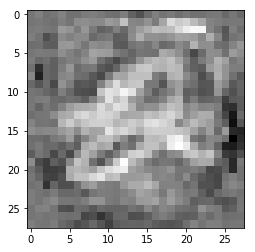

In [32]:
plt.imshow(hacked_image[0], cmap='gray')

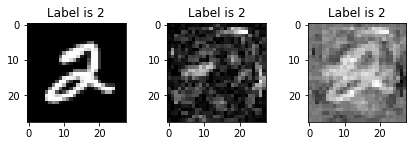

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.tight_layout()
images = [x_train_two[0], abs(x_train_two[0]-hacked_image[0]), hacked_image[0]]
titles = ["Original image", "Delta", "adversarial image"]
for i, col in enumerate(ax):
    col.set_title('Label is {label}'.format(label=y_train_two[ix]))
    col.imshow(images[i], cmap='gray')
plt.show()